Cost after epoch 0: 0.4958
Cost after epoch 5: 0.2916
Cost after epoch 10: 0.2351
Cost after epoch 15: 0.2030
Cost after epoch 20: 0.1802
Cost after epoch 25: 0.1612
Cost after epoch 30: 0.1462
Cost after epoch 35: 0.1378
Cost after epoch 40: 0.1290
Cost after epoch 45: 0.1187
Cost after epoch 50: 0.1123
Cost after epoch 55: 0.1116


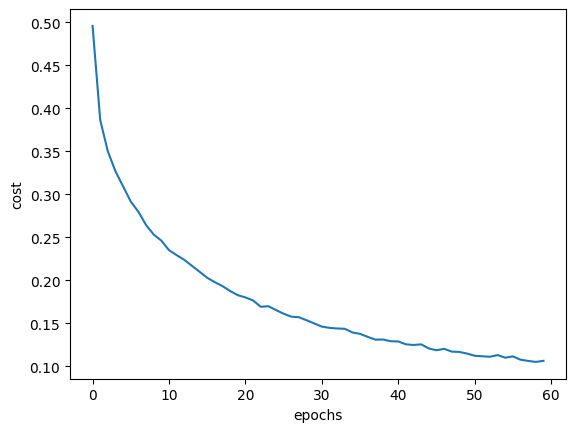


Train Accuracy:
Accuracy: 98.29%

Test Accuracy:
Accuracy: 89.85%


In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

def load_and_prepare_data():
    (train_x_orig, train_y_orig), (test_x_orig, test_y_orig) = fashion_mnist.load_data()
    train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
    test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
    train_x = train_x_flatten / 255.
    test_x = test_x_flatten / 255.
    train_y = one_hot_encoder(train_y_orig, 10)
    test_y = one_hot_encoder(test_y_orig, 10)
    return train_x, train_y, test_x, test_y

def one_hot_encoder(Y, C):
    Y_squeezed = np.squeeze(Y)
    Y_one_hot = np.eye(C)[Y_squeezed].T
    return Y_one_hot


def relu(Z):
    return np.maximum(0, Z), Z

def softmax(Z):
    t = np.exp(Z - np.max(Z, axis=0))
    A = t / np.sum(t, axis=0, keepdims=True)
    return A, Z

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ


def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * np.sqrt(2 / layer_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        # Initialize Batch Norm parameters (gamma and beta) for hidden layers
        if l < L - 1:
            parameters['gamma' + str(l)] = np.ones((layer_dims[l], 1))
            parameters['beta' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

# --- 4. FORWARD PROPAGATION (with Batch Norm) ---

def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    return Z, (A, W, b)

def batchnorm_forward(Z, gamma, beta, epsilon=1e-8):
    # Calculate mean and variance over the mini-batch
    mu = np.mean(Z, axis=1, keepdims=True)
    variance = np.var(Z, axis=1, keepdims=True)

    # Normalize Z
    Z_norm = (Z - mu) / np.sqrt(variance + epsilon)

    # Scale and shift
    Z_tilde = gamma * Z_norm + beta

    cache = (Z, Z_norm, mu, variance, gamma, epsilon)
    return Z_tilde, cache


def L_model_forward(X, parameters, keep_prob=1.0):
    caches = []
    A = X
    L = len(parameters) // 3 + 1 # Number of layers

    for l in range(1, L):
        A_prev = A
        W, b = parameters['W' + str(l)], parameters['b' + str(l)]
        Z, linear_cache = linear_forward(A_prev, W, b)

        bn_cache = None
        activation_fn = "softmax"
        if l < L - 1:
            gamma, beta = parameters['gamma' + str(l)], parameters['beta' + str(l)]
            Z, bn_cache = batchnorm_forward(Z, gamma, beta)
            activation_fn = "relu"

        A, activation_cache = (relu(Z) if activation_fn == "relu" else softmax(Z))

        D = None
        if keep_prob < 1.0 and l < L-1:
            D = np.random.rand(A.shape[0], A.shape[1]) < keep_prob
            A = A * D / keep_prob

        caches.append((linear_cache, bn_cache, activation_cache, D))

    return A, caches


def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    L = len(parameters) // 3 + 1
    cross_entropy_cost = -1/m * np.sum(Y * np.log(AL + 1e-8))

    L2_cost = sum(np.sum(np.square(parameters['W' + str(l)])) for l in range(1, L))

    return cross_entropy_cost + (lambd / (2 * m)) * L2_cost # L2 Regularization


def batchnorm_backward(dZ_tilde, cache):
    Z, Z_norm, mu, var, gamma, epsilon = cache
    m = Z.shape[1]

    dZ_norm = dZ_tilde * gamma
    dvar = np.sum(dZ_norm * (Z - mu) * -0.5 * (var + epsilon)**(-1.5), axis=1, keepdims=True)
    dmu = np.sum(dZ_norm * -1 / np.sqrt(var + epsilon), axis=1, keepdims=True) + dvar * np.sum(-2 * (Z - mu), axis=1, keepdims=True) / m

    dZ = dZ_norm / np.sqrt(var + epsilon) + dvar * 2 * (Z - mu) / m + dmu / m
    dgamma = np.sum(dZ_tilde * Z_norm, axis=1, keepdims=True)
    dbeta = np.sum(dZ_tilde, axis=1, keepdims=True)

    return dZ, dgamma, dbeta

def L_model_backward(AL, Y, caches, lambd, keep_prob):
    grads = {}
    L = len(caches)
    dZ = AL - Y # Derivative for softmax output layer

    for l in reversed(range(L)):
        linear_cache, bn_cache, activation_cache, D = caches[l]

        if l < L-1 :
            dA = grads["dA" + str(l + 1)]
            if keep_prob < 1.0:
                dA = dA * D / keep_prob
            dZ = relu_backward(dA, activation_cache)

        if bn_cache:
            dZ, grads["dgamma" + str(l + 1)], grads["dbeta" + str(l + 1)] = batchnorm_backward(dZ, bn_cache)

        A_prev, W, b = linear_cache
        m = A_prev.shape[1]

        grads["dW" + str(l + 1)] = (1./m) * np.dot(dZ, A_prev.T) + (lambd / m) * W
        grads["db" + str(l + 1)] = (1./m) * np.sum(dZ, axis=1, keepdims=True)
        grads["dA" + str(l)] = np.dot(W.T, dZ)

    return grads

# --- 7. PARAMETER UPDATE (Adam) ---

def initialize_adam(parameters):
    L = len(parameters) // 3 + 1
    v, s = {}, {}
    for l in range(1, L):
        v["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
        if l < L - 1:
            v["dgamma" + str(l)] = np.zeros_like(parameters["gamma" + str(l)])
            v["dbeta" + str(l)] = np.zeros_like(parameters["beta" + str(l)])
    s = {key: np.zeros_like(val) for key, val in v.items()}
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(parameters) // 3 + 1

    for l in range(1, L):
        # Correctly loop over W, b and conditionally over gamma, beta for hidden layers
        for param_name in ["W", "b"] + (["gamma", "beta"] if l < L - 1 else []):
            key = param_name + str(l)
            grad_key = "d" + key

            v[grad_key] = beta1 * v[grad_key] + (1 - beta1) * grads[grad_key]
            s[grad_key] = beta2 * s[grad_key] + (1 - beta2) * np.square(grads[grad_key])

            v_corrected = v[grad_key] / (1 - beta1 ** t)
            s_corrected = s[grad_key] / (1 - beta2 ** t)

            parameters[key] -= learning_rate * v_corrected / (np.sqrt(s_corrected) + epsilon)

    return parameters, v, s

# --- 8. MINI-BATCHES & TRAINING LOOP ---
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0], m))

    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(num_complete_minibatches):
        mini_batches.append((shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size],
                             shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]))
    if m % mini_batch_size != 0:
        mini_batches.append((shuffled_X[:, num_complete_minibatches*mini_batch_size:],
                             shuffled_Y[:, num_complete_minibatches*mini_batch_size:]))
    return mini_batches

def L_layer_model(X, Y, layers_dims, initial_learning_rate=0.001, decay_rate=0.1, num_epochs=30,
                    mini_batch_size=64, lambd=0.0, keep_prob=1.0):
    costs, t, m = [], 0, X.shape[1]
    parameters = initialize_parameters_deep(layers_dims)
    v, s = initialize_adam(parameters)

    for i in range(num_epochs):
        learning_rate = initial_learning_rate / (1 + decay_rate * i)
        minibatches = random_mini_batches(X, Y, mini_batch_size, i)
        epoch_cost = 0

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            AL, caches = L_model_forward(minibatch_X, parameters, keep_prob)
            cost = compute_cost(AL, minibatch_Y, parameters, lambd)
            epoch_cost += cost
            grads = L_model_backward(AL, minibatch_Y, caches, lambd, keep_prob)
            t += 1
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate)

        if i % 5 == 0:
            print(f"Cost after epoch {i}: {epoch_cost / len(minibatches):.4f}")
        costs.append(epoch_cost / len(minibatches))

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost'); plt.xlabel('epochs')
    plt.show()
    return parameters

# --- 9. PREDICTION ---
def predict(X, y, parameters):
    probas, _ = L_model_forward(X, parameters, keep_prob=1.0)
    p = np.argmax(probas, axis=0)
    y_indices = np.argmax(y, axis=0)
    accuracy = np.mean(p == y_indices) * 100
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# --- 10. EXECUTION ---
if __name__ == '__main__':
    train_x, train_y, test_x, test_y = load_and_prepare_data()

    layers_dims = [784, 128, 64, 10]

    # New hyperparameters tuned FOR Batch Normalization
    parameters = L_layer_model(train_x, train_y, layers_dims,
                               initial_learning_rate=0.01,
                               num_epochs=60,
                               lambd=0.0,
                               keep_prob=0.9,
                               decay_rate=0.1)

    print("\nTrain Accuracy:")
    predict(train_x, train_y, parameters)
    print("\nTest Accuracy:")
    predict(test_x, test_y, parameters)